In [40]:
import os
import numpy as np
import SimpleITK as sitk
import torch
from torch.autograd import Variable
from unet3d import UNet
import progressbar
os.environ['CUDA_VISIBLE_DEVICES']='1'
print("Done")

Done


In [41]:
from iterator import BasicVolumeIterator
from pred_utils import calc_pad_for_fit, calc_pad_for_pred_loss, crop_pad_width
print("Done")

Done


In [42]:
patch_size = [116, 132, 132]
out_size = [28, 44, 44]
print("Done")

Done


In [43]:
model = UNet(n_ch = 1, n_class = 2).cuda()
ckpt = torch.load('models/model_epoch45.bin')
model.load_state_dict(ckpt);
model.eval();
print("Done")

Done


In [44]:
import scipy.ndimage as snd
from utils import resample

img_path = '/mnt/data/LiverCT/Parenchyma/LITS/val/volume-100.nii'

img = sitk.ReadImage(img_path)

#Get the spacing b/w the original image
input_spacing = img.GetSpacing()
img_size = img.GetSize()
print("Original Image size: ", img_size)

img = resample(img, (1.0, 1.0, 1.0), interpolator = sitk.sitkLinear)

img_arr = sitk.GetArrayFromImage(img)
img_arr = snd.zoom(img_arr, zoom = (0.5, 0.5, 0.5), order = 1)

print('img arr shape : ', img_arr.shape)
pad_size1 = calc_pad_for_fit(img_arr.shape, out_size)
print('pad size 1 : ', pad_size1)
pad_size2 = calc_pad_for_pred_loss(patch_size, out_size)
print('pad size 2 : ', pad_size2)

pad_size_to_crop = pad_size1
tot_pad_size = [(x[0]+y[0], x[1]+y[1]) for x,y in zip(pad_size1, pad_size2)]
img_arr = np.clip(img_arr, -100, 400)
img_arr = (np.float32(img_arr) +100)/(250) - 1

img_arr_padded = np.pad(img_arr, tot_pad_size, mode = 'constant')

zeros_arr = np.zeros(img_arr.shape)
dummy_output_arr_to_be_predicted = np.pad(zeros_arr, pad_size1, mode = 'constant')
print("Done")

Original Image size:  (512, 512, 685)
img arr shape :  (240, 179, 179)
pad size 1 :  ((6, 6), (20, 21), (20, 21))
pad size 2 :  [(44, 44), (44, 44), (44, 44)]
Done


In [45]:
input_spacing

(0.69921875, 0.69921875, 0.6999999284744263)

In [46]:
inp_itr = BasicVolumeIterator(img_arr_padded, patch_size, out_size)
out_itr = BasicVolumeIterator(dummy_output_arr_to_be_predicted, out_size, out_size)
print("Done")

Done


In [47]:
patch_count = out_itr.get_num_patches()
bar = progressbar.ProgressBar(patch_count).start()
count = 0
print('Patch count : ', patch_count)
while inp_itr.is_not_over():
    input_arr = inp_itr.get_patch().reshape(1,1,116,132,132)
#     print(input_arr.min(), input_arr.max())
    inp_itr.move_coords()
    input_arr = Variable(torch.from_numpy(input_arr).float().cuda(), volatile = True)
    pred_arr = model(input_arr)
    pred_arr = pred_arr.argmax(dim = 1)
    pred_arr = pred_arr.data.cpu().numpy()
    unq = np.unique(pred_arr)
    if count % 100 == 0:
        if unq.max() > 0:
            print(unq)
    out_itr.set_patch(pred_arr[0])
    out_itr.move_coords()
    bar.update(count+1)
    count = count + 1
output_arr = out_itr.vol_array
print(output_arr.shape)
output_arr = crop_pad_width(output_arr, pad_size_to_crop)
# np.save('/mnt/sdb1/intern_data/pix2pix_wbce_pet3d/test_outputs/0_pred.npy', output_arr)
print("Done")

/mnt/data/venv/pytorch1.1/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Patch count :  225


(252, 220, 220)
Done


In [48]:
print(img_arr.shape, output_arr.shape, pad_size1)

(240, 179, 179) (240, 179, 179) ((6, 6), (20, 21), (20, 21))


In [ ]:
# extract (ground truth) label array for comparing with prediction

lbl_path = '/mnt/data/LiverCT/Parenchyma/LITS/val/segmentation-100.nii'

lbl = sitk.ReadImage(lbl_path)
zz = lbl
lbl_size = lbl.GetSize()
spacing = lbl.GetSpacing()

lbl = resample(lbl, (1.0, 1.0, 1.0), interpolator = sitk.sitkLinear)

lbl_arr = sitk.GetArrayFromImage(lbl)
lbl_arr[lbl_arr == 2] = 1
lbl_arr = np.uint8(snd.zoom(lbl_arr, zoom = (0.5, 0.5, 0.5), order = 0))
print("Done")

Done


In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

print(np.unique(output_arr))
# print(output_arr.sum())
for idx in range(output_arr.shape[0]):
    if idx %10 == 0:
        print(idx)
        plt.figure()
        slc = output_arr[idx]
        print(np.unique(slc))
        plt.subplot(1,2,1)
        plt.imshow(slc, cmap = 'gray')
        plt.subplot(1,2,2)
        plt.imshow(lbl_arr[idx], cmap = 'gray')
        plt.show()

In [32]:
#Converting the predicted images back to it's original space
img_arr.shape
output_arr.shape
np.unique(output_arr)

array([0.])

In [33]:
final_seg = snd.zoom(output_arr, zoom = (1/0.5, 1/0.5, 1/0.5), order = 1)
final_seg = sitk.GetImageFromArray(final_seg)
final_seg = resample(final_seg, (input_spacing[0], input_spacing[1], input_spacing[2]), interpolator = sitk.sitkLinear)
#final_seg = resample(final_seg, (input_spacing[0], input_spacing[1], input_spacing[2]), interpolator = sitk.sitkNearestNeighbor)
final_seg.GetSize()

(512, 512, 686)

In [34]:
print("Image size before resampling and zoom: ", img_size)
print("Image size after resampling and zoom: ", img_arr.shape)
print("Label size: ", lbl_size)
print("Predicted Label size by the network: ", output_arr.shape)
print("Predicted Label size after undoing all the things: ", final_seg.GetSize())
print("Spacing in the image space: ", input_spacing)
print("Spacing in the transformed space: ", img.GetSpacing())

Image size before resampling and zoom:  (512, 512, 685)
Image size after resampling and zoom:  (240, 179, 179)
Label size:  (512, 512, 685)
Predicted Label size by the network:  (240, 179, 179)
Predicted Label size after undoing all the things:  (512, 512, 686)
Spacing in the image space:  (0.69921875, 0.69921875, 0.6999999284744263)
Spacing in the transformed space:  (1.0, 1.0, 1.0)


In [15]:
z = sitk.GetArrayFromImage(final_seg)
z[z <= 0.5] = 0
z[z >= 0.5] = 1
zz = sitk.GetArrayFromImage(zz)
zz[zz == 2] = 1
#z = z[:,:512,:512]

zz = zz[:623,:,:]
zz.shape

(623, 512, 512)

In [35]:
z = sitk.GetArrayFromImage(final_seg)
z = z[:685]

z[z <= 0.5] = 0
z[z >= 0.5] = 1

zz = sitk.GetArrayFromImage(zz)
zz[zz == 2] = 1
np.unique(zz)

array([0, 1], dtype=uint8)

In [15]:
np.unique(z)

array([0., 1.])

In [36]:
#Now do the DICE

dice = np.sum(2.0*(q*zz))/(np.sum(q) + np.sum(zz))
#dice = np.sum(2.0*(z*zz))/(np.sum(z) + np.sum(zz))

dice

0.0

In [159]:
dice24 
dice130

0.856895958698147

In [190]:
dice130 = dice

In [38]:
#Largest connected component segmentation

import numpy as np
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

q = getLargestCC(z)
q.shape

AssertionError: 

In [ ]:
import matplotlib.pyplot as plt
for i in range(100):
    plt.imshow(q[i+400,:,:], cmap="gray")
    plt.show()
    plt.imshow(zz[i+400,:,:], cmap="gray")
    plt.show()

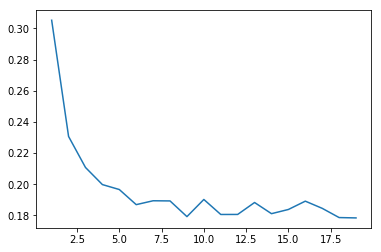

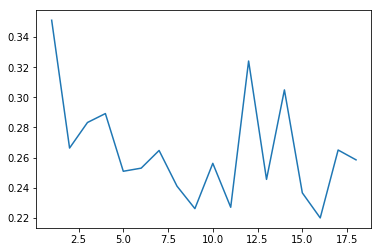

In [25]:
loss1 = np.load('loss/loss1_18.npy')
loss2 = np.load('loss/loss2_18.npy')
t = np.arange(19)
t = t+1
import matplotlib.pyplot as plt
plt.plot(t,loss1)
plt.show()
plt.plot(t[:18],loss2)
plt.show()